In [4]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import tensorflow as tf
from tensorflow.keras import layers
import random

In [5]:
tf.test.is_built_with_cuda()

True

In [6]:
tf.config.list_physical_devices('GPU')

[]

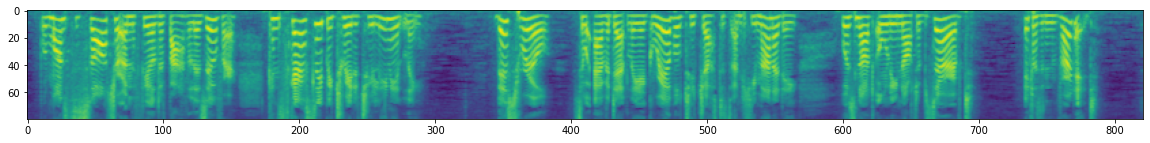

In [7]:
def show_mel_spectra(img_pth="train_2/clean/104/104_123365_104-123365-0003.npy"):
    plt.figure(figsize=(20,6))
    mel_img=np.load(img_pth)
    plt.imshow(mel_img.astype(np.float64).T)

show_mel_spectra()

In [8]:
IMG_SHAPE = (224, 224, 3)

In [9]:
class ClassificationDataGen(tf.keras.utils.Sequence):
    num_classes = 2
    clean_label = ("clean", 0) # имя класса и его численный лейбл
    noisy_label = ("noisy", 1)
    
    def __init__(self, data_folders : list,
                 batch_size,
                 input_size=IMG_SHAPE,
                 shuffle=True):

        self.batch_size = batch_size
        self.input_size = input_size
        self.shuffle = shuffle

        self.file_paths = []
        for data_folder in data_folders:
            self.file_paths += glob(f"{data_folder}/clean/*/*.npy") + glob(f"{data_folder}/noisy/*/*.npy")
            random.shuffle(self.file_paths)

        self.n = len(self.file_paths)

    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.file_paths)

    def __load_image(self, path, target_size):
        image_arr = np.expand_dims(np.load(path), axis=-1)
        image_arr = np.dstack([image_arr for _ in range(self.input_size[-1])])
        image_arr = tf.image.resize(image_arr,(target_size[0], target_size[1])).numpy()
        return image_arr/255.

    @classmethod
    def __get_image_label(cls, path):
        label = cls.clean_label[1] if cls.clean_label[0] in path else cls.noisy_label[1]
        return tf.keras.utils.to_categorical(label, num_classes=cls.num_classes)

    def __get_data(self, file_path_batches):
        X_batch = np.asarray([self.__load_image(pth, self.input_size) for pth in file_path_batches])
        y_batch = np.asarray([self.__get_image_label(pth) for pth in file_path_batches])
        return X_batch, y_batch

    def __getitem__(self, index):
        file_path_batches = self.file_paths[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = self.__get_data(file_path_batches)        
        return X, y

    def __len__(self):
        return self.n // self.batch_size


In [10]:
traingen = ClassificationDataGen(data_folders=["train_1", "train_2"], batch_size=16)
valgen = ClassificationDataGen(data_folders=["train_1", "train_2"], batch_size=16)

In [11]:
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet',
                                               input_tensor=tf.keras.Input(shape=IMG_SHAPE))
base_model.trainable = True
# construct the head of the model that will be placed on top of the
# the base model
headModel = base_model.output
headModel = layers.Flatten(name="flatten")(headModel)
headModel = layers.Dense(512, activation="relu")(headModel)
headModel = layers.Dense(256, activation="relu")(headModel)
headModel = layers.Dense(128, activation="relu")(headModel)
headModel = layers.Dropout(0.2)(headModel)
headModel = layers.Dense(1, activation="softmax")(headModel)
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = tf.keras.Model(inputs=base_model.input, outputs=headModel)

2022-08-25 20:23:19.016834: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-08-25 20:23:19.016900: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1261] Device interconnect StreamExecutor with strength 1 edge matrix:
2022-08-25 20:23:19.016911: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1267]      


In [12]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [13]:
model.fit(traingen,
          validation_data=valgen,
          epochs=10)

2022-08-25 20:23:22.703430: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-08-25 20:23:22.723693: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3492915000 Hz


Epoch 1/10
 592/3000 [====>.........................] - ETA: 46:34 - loss: 0.7615 - accuracy: 0.5000